In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from gensim import models, corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter

In [3]:
nltk.download('stopwords')

# Import dataset
characters_df = pd.read_csv("./dataset/Characters.csv", sep=";")
movie1_df = pd.read_csv("./dataset/Harry Potter 1.csv", sep=";")
movie2_df = pd.read_csv("./dataset/Harry Potter 2.csv", sep=";")
movie3_df = pd.read_csv("./dataset/Harry Potter 3.csv", sep=";")
potions_df = pd.read_csv("./dataset/Potions.csv", sep=";")
other_characters_df = pd.read_csv("./dataset/shortversioncharacters.csv", sep=",")
spells_df = pd.read_csv("./dataset/Spells.csv", sep=";")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/duminduakalanka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Analyze characters
class Character():
    def __init__(self, df):
        self.data = df
        f = open("./resources/character_mapping.json", "r")
        self.character_mapping = json.load(f)
        f.close()
        
    def map(self, character_name):
        # Map similar character to a group
        character_name = character_name.strip()
        if character_name in self.character_mapping and self.character_mapping[character_name] is not None:
            return self.character_mapping[character_name].title()
        else:
            return character_name.title()

In [5]:
# Movie
movie1_df['Movie'] = 'Harry Potter and the Sorcerers Stone'
movie2_df['Movie'] = 'Harry Potter and the Chamber of Secrets'
movie3_df['Movie'] = 'Harry Potter and the Prisoner of Azkaban'

movies_list = [movie1_df, movie2_df, movie3_df]

class Movie():
    def __init__(self, df: list):
        self.movie_list = df
        self.movies_df = self.combine_movies()

    def combine_movies(self):
        # Combine movies
        for i in self.movie_list:
            i.columns = map(str.title, i.columns)
        
        return pd.concat([movie1_df, movie2_df, movie3_df], ignore_index=False)
        
    def preprocess(self):
        # Strip the spaces in character to remove identifying the same character twice
        self.movies_df["Character"] = self.movies_df.apply(lambda row: row["Character"].strip().title(), axis=1)


In [6]:
# Preprocess
def preprocessing():
    c = Character(characters_df)
    
    m = Movie(movies_list)
    m.preprocess()

    m.movies_df["Character"] = m.movies_df.apply(lambda row: c.map(row["Character"]), axis=1)

    return c,m

c, m = preprocessing()

In [12]:
grouped = m.movies_df.groupby("Character").count().reset_index()
grouped.sort_values('Sentence', ascending=False).head(10)
grouped = grouped.loc[grouped["Sentence"]>10]
grouped

,Character,Sentence,Movie
1,Aragog,20,20
2,Aunt Marge,37,37
3,Aunt Petunia,55,55
14,Dobby,69,69
15,Draco Malfoy,131,131
16,Dudley,20,20
17,Dumbledore,239,239
19,Filch,50,50
20,Firenze,14,14
22,Flitwick,13,13


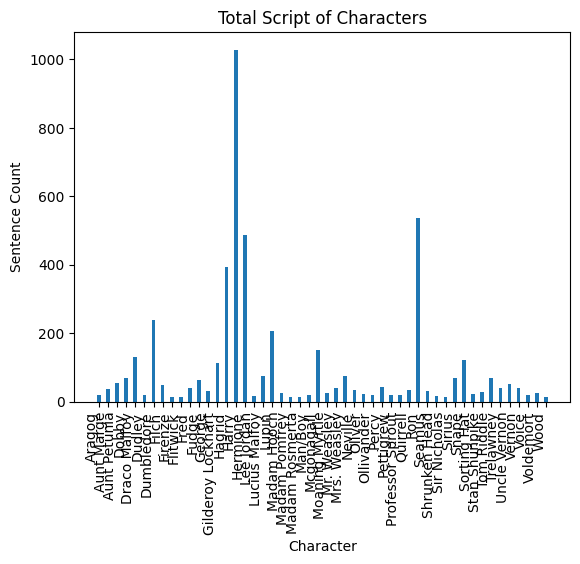

In [14]:
# create histograms for length of total script
def histogram(x):
    pd.Series(x).plot(kind='bar')


plt.bar(grouped["Character"], grouped["Sentence"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Sentence Count')
plt.title('Total Script of Characters')

# Show the chart
plt.show()


In [9]:
# TODO Could not find a list of personal pronouns here. https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
#      Therefore Used nltk pos tags

def countPersonalPronouns(sentence):
    words = nltk.word_tokenize(sentence)

    # Find personal pronouns
    personal_pronouns = [word for word, tag in nltk.pos_tag(words) if tag == 'PRP']

    return len(personal_pronouns)

m.movies_df["PRP_Count"] = m.movies_df.apply(lambda row: countPersonalPronouns(row["Sentence"]), axis=1)
grouped_with_PRP = m.movies_df.groupby("Character").sum().reset_index()
grouped_with_PRP.sort_values('PRP_Count', ascending=False)

,Character,Sentence,Movie,PRP_Count
37,Harry,"Yes, Aunt Petunia.Yes, Uncle Vernon.He's aslee...",Harry Potter and the Sorcerers StoneHarry Pott...,859
71,Ron,Excuse me. Do you mind?Everywhere else is full...,Harry Potter and the Sorcerers StoneHarry Pott...,413
40,Hermione,Has anyone seen a toad?A boy named Neville's l...,Harry Potter and the Sorcerers StoneHarry Pott...,378
36,Hagrid,"Professor Dumbledore, sir.Professor McGonagall...",Harry Potter and the Sorcerers StoneHarry Pott...,335
17,Dumbledore,"I should've known that you would be here, Prof...",Harry Potter and the Sorcerers StoneHarry Pott...,234
...,...,...,...,...
64,Penelope Clearwater,There's Nearly Headless Nick.,Harry Potter and the Chamber of Secrets,0
63,Parvati,Riddikulus!,Harry Potter and the Prisoner of Azkaban,0
34,Griphook,"Vault 687.Lamp, please.Key, please.Vault 713.S...",Harry Potter and the Sorcerers StoneHarry Pott...,0
35,Gryffindors,Yay!,Harry Potter and the Sorcerers Stone,0


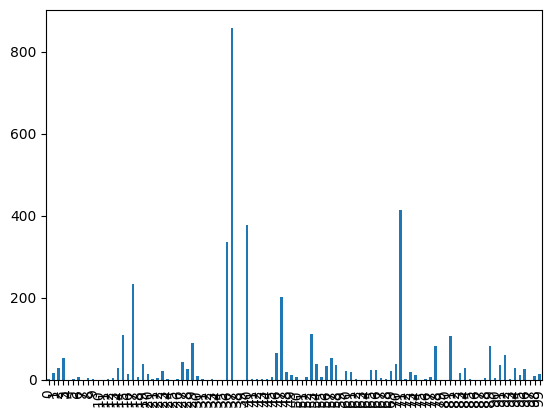

In [10]:
histogram(grouped_with_PRP["PRP_Count"])

In [11]:
# Positive and negative sentiment count'

positive_lexicon =  []
negative_lexicon =  []

with open("./resources/opinion-lexicon-English/positive-words.txt", "r") as file:
    for line in file:
        positive_lexicon.append(line.strip())

with open("./resources/opinion-lexicon-English/negative-words.txt", "r") as file:
    for line in file:
        negative_lexicon.append(line.strip())



In [12]:
def positiveSentimentWordCount(sent):
    count = 0
    words = nltk.word_tokenize(sent)
    count += sum(1 for w in words if w in positive_lexicon)
    return count
    

def negativeSentimentWordCount(sent):
    count=0
    words = nltk.word_tokenize(sent)
    count += sum(1 for w in words if w in negative_lexicon)
    return count

m.movies_df["positive_words"] = m.movies_df.apply(lambda row: positiveSentimentWordCount(row["Sentence"]), axis=1)
m.movies_df["negative_words"] = m.movies_df.apply(lambda row: negativeSentimentWordCount(row["Sentence"]), axis=1)



In [13]:
# Plot positive sentiment
grouped_with_pos_neg = m.movies_df.groupby("Character").sum().reset_index()

# Remove characters with 0 positive and negative sentiments in all scripts
grouped_with_pos_neg = grouped_with_pos_neg.loc[grouped_with_pos_neg["positive_words"] > 0]
grouped_with_pos_neg = grouped_with_pos_neg.loc[grouped_with_pos_neg["negative_words"] > 0]

grouped_with_pos_neg


,Character,Sentence,Movie,PRP_Count,positive_words,negative_words
1,Aragog,Who is it?Hagrid?Is that you?Yes.Hagrid has ne...,Harry Potter and the Chamber of SecretsHarry P...,15,2,6
2,Aunt Marge,"You still here, are you?Don't say 'yes' in tha...",Harry Potter and the Prisoner of AzkabanHarry ...,28,2,11
3,Aunt Petunia,"Up. Get up!Now!Here he comes, the birthday boy...",Harry Potter and the Sorcerers StoneHarry Pott...,52,18,7
6,Bem,"Not the Grin, you idiot. The Grim.Taking form ...",Harry Potter and the Prisoner of AzkabanHarry ...,5,2,4
14,Dobby,"Ha- ha- ha! Ha, ha! Ho, ho, ho! Ha, ha! Harry ...",Harry Potter and the Chamber of SecretsHarry P...,27,14,14
15,Draco Malfoy,"It's true then, what they're saying on the tra...",Harry Potter and the Sorcerers StoneHarry Pott...,108,14,28
17,Dumbledore,"I should've known that you would be here, Prof...",Harry Potter and the Sorcerers StoneHarry Pott...,234,81,49
18,Fat Lady,"Password?No, no. Wait, wait.Watch this.Amazing...",Harry Potter and the Sorcerers StoneHarry Pott...,5,2,2
19,Filch,"Anyone here, my sweet? Come on.Who's there?! I...",Harry Potter and the Sorcerers StoneHarry Pott...,37,5,10
20,Firenze,"Harry Potter, you must leave. You are known to...",Harry Potter and the Sorcerers StoneHarry Pott...,13,4,6


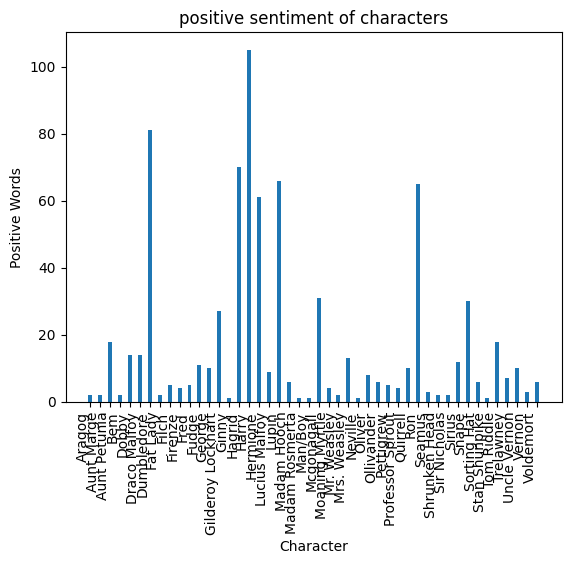

In [14]:

plt.bar(grouped_with_pos_neg["Character"], grouped_with_pos_neg["positive_words"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Positive Words')
plt.title('positive sentiment of characters')

# Show the chart
plt.show()

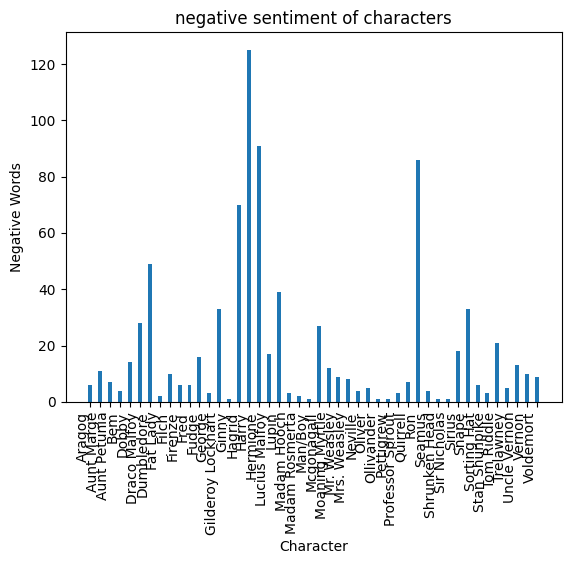

In [15]:

plt.bar(grouped_with_pos_neg["Character"], grouped_with_pos_neg["negative_words"], width = 0.4)

plt.xticks(rotation=90, ha='right')

# Label the chart
plt.xlabel('Character')
plt.ylabel('Negative Words')
plt.title('negative sentiment of characters')

# Show the chart
plt.show()

In [46]:
combined_sent_df = m.movies_df.groupby("Character").sum().reset_index()

In [50]:
def preprocessingForLDA(corp):
    # Get the list of English stop words
    custom_stop_words = ["go","get","The","And", "See", "No", "Back","Give", "would", "catch", "See", "look", "go", "well"]
    stop_words = set(stopwords.words('english')).union(custom_stop_words)
    
    # remove sequence of dots
    corp = re.sub(r'\.{2,}', ' ', corp)
    
    # Tokenize the sentences
    sentences = sent_tokenize(corp)
    prep_sentences = []
    
    # lemmatize words
    wordnet_lemmatizer = WordNetLemmatizer()

    tokens = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in words]

        #get rid of numbers and Stopwords
        words = [word for word in words if word.isalpha() and word not in stop_words]
        
        # Remove punctuation
        words = [word for word in words if word not in string.punctuation]

        # Remove pronouns
        words = [word for word in words if nltk.pos_tag([word])[0][1] != "PRP"]

        if len(words) != 0:
            tokens.extend(words)
            prep_sentences.append(words)
        
    corp = ' '.join(tokens)
    
    return tokens, corp, prep_sentences

In [51]:
def ldaModelling(corp):
    num_topics = 5
    dictionary = corpora.Dictionary(corp)
    corpus = [dictionary.doc2bow(doc) for doc in corp]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30)
    return lda_model

In [53]:
topics_df = pd.DataFrame(columns = ["Character", "t1", "t2", "t3", "t4", "t5"])
for index,row in combined_sent_df.iterrows():
    prep_words, prep_text, prep_sent = preprocessingForLDA(row["Sentence"])
    if len(prep_sent) == 0:
        print(row["Character"])
    ldamodel1 = ldaModelling(prep_sent)
    topics = ldamodel1.show_topics(num_topics=5, num_words=5) 
    data = {"Character" : row["Character"], "t1": topics[0][1], "t2": topics[1][1], "t3": topics[2][1], "t4": topics[3][1], "t5": topics[4][1]}
    topics_df.loc[len(topics_df)] = data

Harry-Ron-Hermione


ValueError: cannot compute LDA over an empty collection (no terms)

In [41]:
# topics_df

In [33]:
def topic2list(topic):
    words = [word.strip('".+*0123456789') for word in topic.split()]
    
    # Filter out empty strings
    words = [word for word in words if word]
    return words

In [34]:
topic2list('0.041*"catch" + 0.041*"seeker" + 0.041*"ball" + 0.041*"fast" + 0.041*"damn"')

['catch', 'seeker', 'ball', 'fast', 'damn']

In [35]:
def createWordnetPlot(word_frequencies):
    wordcloud = WordCloud(width=800, height=400, background_color='white')

    # Generate the word cloud from the word frequency data
    wordcloud.generate_from_frequencies(word_frequencies)
    
    # Display the word cloud using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def countWords(df):
    word_list = []

    for i,row in df.iterrows():
        word_list.extend(topic2list(row["t1"]))
        word_list.extend(topic2list(row["t2"]))
        word_list.extend(topic2list(row["t3"]))
        word_list.extend(topic2list(row["t4"]))
        word_list.extend(topic2list(row["t5"]))

    # Use Counter to count the occurrences of each word
    word_count = Counter(word_list)
    
    # Convert the result to a dictionary if needed
    word_count_dict = dict(word_count)
    
    return word_count_dict


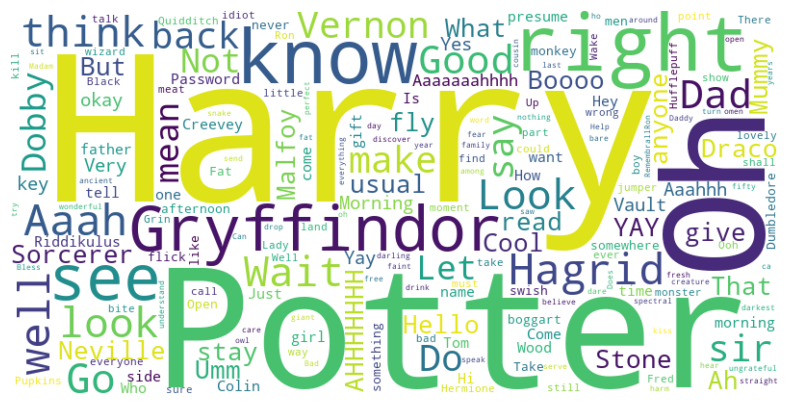

In [42]:
createWordnetPlot(countWords(topics_df))